In [1]:
"""
    使用XGBoost， 采用五折交叉验证
    MAE = 497
    
    模型融合：
    1）相同模型下的多个子模型，比如都用 XGBoost,采用5个子模型进行融合
    2）不同模型的融合，比如XGBoost + LightGBM 
    
    模型融合 不是在模型内进行融合
    而是对于模型的预测结果可进行加权平均（即融合）
    有几个模型，就有几个模型预测的结果
    然后对 预测结果 ，进行加权平均（相加/5)
    
    什么情况下模型融合不好？
    1） 与一个坏的模型进行融合 ： X MAE = 1000, XGBoost = 509 一起融合
     MAE = MEAN ABSOLUTE ERROR
     
     518,521,530,513,580 => 497
""" 
"""
    Baseline:
    1) 确定模型：LightGBM 或者XGBoost
    2) 确定特征: 去掉时间（因为时间特征 还需要做特征处理），去掉一些明显没用的特征，比如 ID ，name
    剩下的特征，放到模型中进行训练
    
    怎么提升:
    1) 利用时间，creat_year
    2) 构造新特征，brand 特征
    662- > 509 
    3) 模型融合 XGBoost,LightGBM
"""

'\n    Baseline:\n    1) 确定模型：LightGBM 或者XGBoost\n    2) 确定特征: 去掉时间（因为时间特征 还需要做特征处理），去掉一些明显没用的特征，比如 ID ，name\n    剩下的特征，放到模型中进行训练\n    \n    怎么提升:\n    1) 利用时间，creat_year\n    2) 构造新特征，brand 特征\n    662- > 509 \n    3) 模型融合 XGBoost,LightGBM\n'

In [2]:
## 基础工具
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
## 通过Pandas对于数据进行读取 (pandas是一个很友好的数据读取函数库)
train_data = pd.read_csv("used_car_train_20200313.csv", sep=' ')
test = pd.read_csv("used_car_testB_20200421.csv", sep=' ')

## 输出数据的大小信息
print('Train data shape:',train_data.shape)
print('TestA data shape:',test.shape)

Train data shape: (150000, 31)
TestA data shape: (50000, 30)


In [4]:
## 通过.head() 简要浏览读取数据的形式
train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [5]:
## 通过 .info() 简要可以看到对应一些数据列名，以及NAN缺失信息
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SaleID             150000 non-null  int64  
 1   name               150000 non-null  int64  
 2   regDate            150000 non-null  int64  
 3   model              149999 non-null  float64
 4   brand              150000 non-null  int64  
 5   bodyType           145494 non-null  float64
 6   fuelType           141320 non-null  float64
 7   gearbox            144019 non-null  float64
 8   power              150000 non-null  int64  
 9   kilometer          150000 non-null  float64
 10  notRepairedDamage  150000 non-null  object 
 11  regionCode         150000 non-null  int64  
 12  seller             150000 non-null  int64  
 13  offerType          150000 non-null  int64  
 14  creatDate          150000 non-null  int64  
 15  price              150000 non-null  int64  
 16  v_

In [6]:
## 通过 .columns 查看列名
train_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SaleID             50000 non-null  int64  
 1   name               50000 non-null  int64  
 2   regDate            50000 non-null  int64  
 3   model              50000 non-null  float64
 4   brand              50000 non-null  int64  
 5   bodyType           48496 non-null  float64
 6   fuelType           47076 non-null  float64
 7   gearbox            48032 non-null  float64
 8   power              50000 non-null  int64  
 9   kilometer          50000 non-null  float64
 10  notRepairedDamage  50000 non-null  object 
 11  regionCode         50000 non-null  int64  
 12  seller             50000 non-null  int64  
 13  offerType          50000 non-null  int64  
 14  creatDate          50000 non-null  int64  
 15  v_0                50000 non-null  float64
 16  v_1                500

In [8]:
## 通过 .describe() 可以查看数值特征列的一些统计信息
train_data.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,150000.000000,150000.000000,1.500000e+05,149999.000000,150000.000000,145494.000000,141320.000000,144019.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,74999.500000,68349.172873,2.003417e+07,47.129021,8.052733,1.792369,0.375842,0.224943,119.316547,12.597160,...,0.248204,0.044923,0.124692,0.058144,0.061996,-0.001000,0.009035,0.004813,0.000313,-0.000688
std,43301.414527,61103.875095,5.364988e+04,49.536040,7.864956,1.760640,0.548677,0.417546,177.168419,3.919576,...,0.045804,0.051743,0.201410,0.029186,0.035692,3.772386,3.286071,2.517478,1.288988,1.038685
min,0.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.168192,-5.558207,-9.639552,-4.153899,-6.546556
25%,37499.750000,11156.000000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243615,0.000038,0.062474,0.035334,0.033930,-3.722303,-1.951543,-1.871846,-1.057789,-0.437034
50%,74999.500000,51638.000000,2.003091e+07,30.000000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.257798,0.000812,0.095866,0.057014,0.058484,1.624076,-0.358053,-0.130753,-0.036245,0.141246
75%,112499.250000,118841.250000,2.007111e+07,66.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265297,0.102009,0.125243,0.079382,0.087491,2.844357,1.255022,1.776933,0.942813,0.680378
max,149999.000000,196812.000000,2.015121e+07,247.000000,39.000000,7.000000,6.000000,1.000000,19312.000000,15.000000,...,0.291838,0.151420,1.404936,0.160791,0.222787,12.357011,18.819042,13.847792,11.147669,8.658418


In [9]:
test.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,50000.000000,50000.000000,5.000000e+04,50000.00000,50000.000000,48496.000000,47076.000000,48032.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,224999.500000,68505.606100,2.003401e+07,47.64948,8.087140,1.793736,0.376498,0.226953,119.766960,12.598260,...,0.248147,0.044624,0.124693,0.058198,0.062113,0.019633,0.002759,0.004342,0.004570,-0.007209
std,14433.901067,61032.124271,5.351615e+04,49.90741,7.899648,1.764970,0.549281,0.418866,206.313348,3.912519,...,0.045836,0.051664,0.201440,0.029171,0.035723,3.764095,3.289523,2.515912,1.287194,1.044718
min,200000.000000,1.000000,1.991000e+07,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.119719,-5.662163,-8.291868,-4.157649,-6.098192
25%,212499.750000,11315.000000,1.999100e+07,11.00000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243436,0.000035,0.062519,0.035413,0.033880,-3.675196,-1.963928,-1.865406,-1.048722,-0.440706
50%,224999.500000,52215.000000,2.003091e+07,30.00000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.257818,0.000801,0.095880,0.056804,0.058749,1.632134,-0.375537,-0.138943,-0.036352,0.136849
75%,237499.250000,118710.750000,2.007110e+07,66.00000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265263,0.101654,0.125470,0.079387,0.087624,2.846205,1.263451,1.775632,0.945239,0.685555
max,249999.000000,196808.000000,2.015121e+07,246.00000,39.000000,7.000000,6.000000,1.000000,19211.000000,15.000000,...,0.291176,0.153403,1.411559,0.157458,0.211304,12.177864,18.789496,13.384828,5.635374,2.649768


# 缺失值补全

In [10]:
train_data['notRepairedDamage'].value_counts()
#train_data['notRepairedDamage'].describe()

0.0    111361
-       24324
1.0     14315
Name: notRepairedDamage, dtype: int64

In [11]:
train_data['notRepairedDamage'].replace('-', '0.0', inplace=True)
test['notRepairedDamage'].replace('-', '0.0', inplace=True)

In [12]:
# 查看数值类型
#train_data.info()
numerical_cols = train_data.select_dtypes(exclude='object').columns
numerical_cols

# 查看分类类型
categorical_cols = train_data.select_dtypes(include='object').columns
categorical_cols

Index(['notRepairedDamage'], dtype='object')

In [13]:
# 特征选择
# drop_cols = ['SaleID', 'regDate', 'creatDate', 'offerType', 'price']
drop_cols = ['SaleID', 'name', 'price']
feature_cols = [col for col in train_data.columns if col not in drop_cols]
print(feature_cols)

['regDate', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode', 'seller', 'offerType', 'creatDate', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14']


# 对日期格式进行处理

In [14]:
"""
train_data['regDate'] = pd.to_datetime(train_data['regDate'],format = '%Y%m%d',errors = 'coerce')
print(train_data['regDate'].head(10))

test['regDate'] = pd.to_datetime(test['regDate'],format = '%Y%m%d',errors = 'coerce')
print(test['regDate'].head(10))

train_data['creatDate'] = pd.to_datetime(train_data['creatDate'],format = '%Y%m%d',errors = 'coerce')
print(train_data['creatDate'].head(10))

test['creatDate'] = pd.to_datetime(test['creatDate'],format = '%Y%m%d',errors = 'coerce')
print(test['creatDate'].head(10))

# 时间多尺度

train_data['regDate_year'] = train_data['regDate'].apply(lambda x : int(str(x)[0:4]))
train_data['regDate_month'] = train_data['regDate'].apply(lambda x : int(str(x)[5:7]))
train_data['regDate_day'] = train_data['regDate'].apply(lambda x : int(str(x)[8:10]))
print(train_data[['regDate_year','regDate_month','regDate_day']].head(10))


test['regDate_year'] = test['regDate'].apply(lambda x : int(str(x)[0:4]))
test['regDate_month'] = test['regDate'].apply(lambda x : int(str(x)[5:7]))
test['regDate_day'] = test['regDate'].apply(lambda x : int(str(x)[8:10]))
print(test[['regDate_year','regDate_month','regDate_day']].head(10))

train_data['creatDate_year'] = train_data['creatDate'].apply(lambda x : int(str(x)[0:4]))
train_data['creatDate_month'] = train_data['creatDate'].apply(lambda x : int(str(x)[5:7]))
train_data['creatDate_day'] = train_data['creatDate'].apply(lambda x : int(str(x)[8:10]))
print(train_data[['creatDate_year','creatDate_month','creatDate_day']].head(10))

test['creatDate_year'] = test['creatDate'].apply(lambda x : int(str(x)[0:4]))
test['creatDate_month'] = test['creatDate'].apply(lambda x : int(str(x)[5:7]))
test['creatDate_day'] = test['creatDate'].apply(lambda x : int(str(x)[8:10]))
print(test[['creatDate_year','creatDate_month','creatDate_day']].head(10))

# 时间datediff
train_data['regDate_diff']= (train_data['regDate'] - train_data['regDate'].min()).dt.days
train_data[['regDate','regDate_diff']]

test['regDate_diff']= (test['regDate'] - train_data['regDate'].min()).dt.days  # test['regDate'].min() =  train_data['regDate'].min()
test[['regDate','regDate_diff']]
"""

"\ntrain_data['regDate'] = pd.to_datetime(train_data['regDate'],format = '%Y%m%d',errors = 'coerce')\nprint(train_data['regDate'].head(10))\n\ntest['regDate'] = pd.to_datetime(test['regDate'],format = '%Y%m%d',errors = 'coerce')\nprint(test['regDate'].head(10))\n\ntrain_data['creatDate'] = pd.to_datetime(train_data['creatDate'],format = '%Y%m%d',errors = 'coerce')\nprint(train_data['creatDate'].head(10))\n\ntest['creatDate'] = pd.to_datetime(test['creatDate'],format = '%Y%m%d',errors = 'coerce')\nprint(test['creatDate'].head(10))\n\n# 时间多尺度\n\ntrain_data['regDate_year'] = train_data['regDate'].apply(lambda x : int(str(x)[0:4]))\ntrain_data['regDate_month'] = train_data['regDate'].apply(lambda x : int(str(x)[5:7]))\ntrain_data['regDate_day'] = train_data['regDate'].apply(lambda x : int(str(x)[8:10]))\nprint(train_data[['regDate_year','regDate_month','regDate_day']].head(10))\n\n\ntest['regDate_year'] = test['regDate'].apply(lambda x : int(str(x)[0:4]))\ntest['regDate_month'] = test['reg

In [15]:
"""
feature_cols.append('regDate_year')
feature_cols.append('creatDate_year')
print(feature_cols)

"""
train_data['regDate_year'] = train_data['regDate'].apply(lambda x : int(str(x)[0:4]))
test['regDate_year'] = test['regDate'].apply(lambda x : int(str(x)[0:4]))

train_data['creatDate_year'] = train_data['creatDate'].apply(lambda x : int(str(x)[0:4]))
test['creatDate_year'] = test['creatDate'].apply(lambda x : int(str(x)[0:4]))

In [16]:
train_data['regDate_year'].value_counts()

2000    10572
1999    10063
2005     9994
2006     9242
2001     9110
2003     9059
2004     8889
2002     8746
2007     8080
1998     7907
2008     7458
2009     7277
1997     6559
2010     5739
2011     5503
1996     4822
2012     4258
1995     4117
2013     2789
2014     2240
1994     2158
1993     1476
2015     1388
1992     1339
1991     1215
Name: regDate_year, dtype: int64

In [17]:
# 定一个统计函数，用于统计某字段的特征
import numpy as np
def show_stats(data):
    print('min: ', np.min(data))
    print('max: ', np.max(data))
    # ptp = max - min
    print('ptp: ', np.ptp(data))
    print('mean: ', np.mean(data))
    print('std: ', np.std(data))
    print('var: ', np.var(data))
# 查看price
show_stats(train_data['price'])

min:  11
max:  99999
ptp:  99988
mean:  5923.327333333334
std:  7501.973469876635
var:  56279605.942732885


In [18]:
import warnings
warnings.filterwarnings('ignore')
#X_data.info()
train_data['notRepairedDamage'] = train_data['notRepairedDamage'].astype('float64')
test['notRepairedDamage'] = test['notRepairedDamage'].astype('float64')

In [19]:
brand_data = train_data.groupby('brand')
all_info = {}
for brand_index,brand_temp in brand_data:
    info = {}
    brand_temp = brand_temp[brand_temp['price']>0]
    info['brand_amount'] = len(brand_temp)
    info['brand_price_max'] = brand_temp.price.max()
    info['brand_price_min'] = brand_temp.price.min()
    info['brand_price_median'] = brand_temp.price.median()
    info['brand_price_mean'] = brand_temp.price.mean()
    info['brand_price_std'] = brand_temp.price.std()
    info['brand_price_ptp'] = info['brand_price_max'] - info['brand_price_min']
    all_info[brand_index] = info
all_info

{0: {'brand_amount': 31480,
  'brand_price_max': 68500,
  'brand_price_min': 13,
  'brand_price_median': 3199.0,
  'brand_price_mean': 5535.36499364676,
  'brand_price_std': 6272.522118575289,
  'brand_price_ptp': 68487},
 1: {'brand_amount': 13794,
  'brand_price_max': 99900,
  'brand_price_min': 15,
  'brand_price_median': 6499.0,
  'brand_price_mean': 9273.31194722343,
  'brand_price_std': 9369.631497175225,
  'brand_price_ptp': 99885},
 2: {'brand_amount': 321,
  'brand_price_max': 59800,
  'brand_price_min': 35,
  'brand_price_median': 7700.0,
  'brand_price_mean': 12037.822429906542,
  'brand_price_std': 10875.89289076972,
  'brand_price_ptp': 59765},
 3: {'brand_amount': 2461,
  'brand_price_max': 37500,
  'brand_price_min': 65,
  'brand_price_median': 4990.0,
  'brand_price_mean': 6482.822429906542,
  'brand_price_std': 5396.327503267485,
  'brand_price_ptp': 37435},
 4: {'brand_amount': 16737,
  'brand_price_max': 99999,
  'brand_price_min': 12,
  'brand_price_median': 6000.0,

In [20]:
brand_stats = pd.DataFrame(all_info).T.reset_index().rename(columns = {'index':'brand'})
train_data = train_data.merge(brand_stats,how = 'left',on = 'brand')
train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_14,regDate_year,creatDate_year,brand_amount,brand_price_max,brand_price_min,brand_price_median,brand_price_mean,brand_price_std,brand_price_ptp
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.914762,2004,2016,10217.0,59900.0,13.0,1800.0,3611.840266,4681.293524,59887.0
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.245522,2003,2016,13794.0,99900.0,15.0,6499.0,9273.311947,9369.631497,99885.0
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,-0.229963,2004,2016,1458.0,45000.0,100.0,8500.0,9858.582990,5425.058140,44900.0
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,-0.478699,1996,2016,14249.0,98000.0,15.0,5400.0,8470.804197,8988.307535,97985.0
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,1.923482,2012,2016,4665.0,31500.0,20.0,2300.0,3306.349411,3343.624586,31480.0


In [21]:
test = test.merge(brand_stats,how = 'left',on = 'brand')
test.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_14,regDate_year,creatDate_year,brand_amount,brand_price_max,brand_price_min,brand_price_median,brand_price_mean,brand_price_std,brand_price_ptp
0,200000,133777,20000501,67.0,0,1.0,0.0,0.0,101,15.0,...,0.803322,2000,2016,31480.0,68500.0,13.0,3199.0,5535.364994,6272.522119,68487.0
1,200001,61206,19950211,19.0,6,2.0,0.0,0.0,73,6.0,...,-0.200542,1995,2016,10217.0,59900.0,13.0,1800.0,3611.840266,4681.293524,59887.0
2,200002,67829,20090606,5.0,5,4.0,0.0,0.0,120,5.0,...,1.027173,2009,2016,4665.0,31500.0,20.0,2300.0,3306.349411,3343.624586,31480.0
3,200003,8892,20020601,22.0,9,1.0,0.0,0.0,58,15.0,...,0.461610,2002,2016,7306.0,68530.0,50.0,1400.0,2438.274843,2974.272776,68480.0
4,200004,76998,20030301,46.0,6,0.0,NaN,0.0,116,15.0,...,0.451014,2003,2016,10217.0,59900.0,13.0,1800.0,3611.840266,4681.293524,59887.0


In [22]:
# 去掉原始的日期自动，添加上新的日期字段
cols = train_data.columns.to_list()
cols.remove('SaleID')
cols.remove('name')
cols.remove('regDate')
cols.remove('creatDate')
cols.remove('price')
print(cols)

['model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode', 'seller', 'offerType', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'regDate_year', 'creatDate_year', 'brand_amount', 'brand_price_max', 'brand_price_min', 'brand_price_median', 'brand_price_mean', 'brand_price_std', 'brand_price_ptp']


In [23]:
# 提取特征列
X_data = train_data[cols]
Y_data = train_data['price']
X_test = test[cols]

In [24]:
X_data.info()  ## 目前都是int / float 类型

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 0 to 149999
Data columns (total 35 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   model               149999 non-null  float64
 1   brand               150000 non-null  int64  
 2   bodyType            145494 non-null  float64
 3   fuelType            141320 non-null  float64
 4   gearbox             144019 non-null  float64
 5   power               150000 non-null  int64  
 6   kilometer           150000 non-null  float64
 7   notRepairedDamage   150000 non-null  float64
 8   regionCode          150000 non-null  int64  
 9   seller              150000 non-null  int64  
 10  offerType           150000 non-null  int64  
 11  v_0                 150000 non-null  float64
 12  v_1                 150000 non-null  float64
 13  v_2                 150000 non-null  float64
 14  v_3                 150000 non-null  float64
 15  v_4                 150000 non-nul

In [25]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   model               50000 non-null  float64
 1   brand               50000 non-null  int64  
 2   bodyType            48496 non-null  float64
 3   fuelType            47076 non-null  float64
 4   gearbox             48032 non-null  float64
 5   power               50000 non-null  int64  
 6   kilometer           50000 non-null  float64
 7   notRepairedDamage   50000 non-null  float64
 8   regionCode          50000 non-null  int64  
 9   seller              50000 non-null  int64  
 10  offerType           50000 non-null  int64  
 11  v_0                 50000 non-null  float64
 12  v_1                 50000 non-null  float64
 13  v_2                 50000 non-null  float64
 14  v_3                 50000 non-null  float64
 15  v_4                 50000 non-null  float64
 16  v_5 

In [26]:
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

# 数据集切分，80% 用于训练，20%用于验证 => MAE : 605
x_train,x_val,y_train,y_val = train_test_split(X_data,Y_data,test_size=0.2)


In [27]:
# 标签泄露：就是特征与label 进行了关联，如果某个构造的特征 与label 进行关联
# model 进行预测的时候，训练集结果会很准确
# 适当的标签泄露是有价值，但是取决于 你的 value_counts 个数
# 如果个数不多，比如40个，是OK的 => 有一些特征的价值 =>相当于聚类的价值
# 如果个数很多，比如15万，是不行的 => ID的作用
len(train_data['brand'].value_counts())

40

In [28]:
"""
    使用XGBoost,采用五折交叉验证
    MAE = 497

"""
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error 

def ensemble_model(clf,train_x,train_y,test):
    # 采用五折交叉验证
    sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=2021)
    result = []
    mean_mae = 0
    
    for k,(train_index,val_index) in enumerate(sk.split(train_x,train_y)):
        # 使用sk 得到训练集，验证集
        train_x_real = train_x.iloc[train_index]
        train_y_real = train_y.iloc[train_index]
        val_x = train_x.iloc[val_index]
        val_y = train_y.iloc[val_index]
        # 子模型训练
        clf = clf.fit(train_x_real,train_y_real)
        val_y_pred = clf.predict(val_x)
        # 子模型评估
        mae_val = mean_absolute_error(val_y,val_y_pred)
        print('第{}个子模型 MAE {}'.format(k+1,mae_val))
        mean_mae +=mae_val/5
        # 使用子模型 对测试集进行预测
        test_y_pred = clf.predict(test)
        result.append(test_y_pred)
    print(mean_mae)
    # 最终结果 = 5个子模型的平均值
    mean_result = sum(result)/5
    return mean_result

In [29]:
%%time
# 创建模型
"""
model = xgb.XGBRegressor(
                        n_estimators= 150, #提升迭代的次数，也就是生成多少基模型
                        learning_rate = 0.1,
                        gamma = 0,
                        colsample_bytree=0.8, #列采样率，也就是特征采样率
                        subsample=0.8, #构建每棵树对样本的采样率
                        max_depth=7, #树的最大深度
                        random_state = 2021
                    )
model.fit(x_train, y_train)
y_pred = model.predict(x_val)
mae = mean_absolute_error(y_val,y_pred)
print('XGBoost MAE :',mae)
"""
# 祖传参数，在有限的时间内，得到还不错的结果
model = xgb.XGBRegressor(
                        n_estimators= 2000, #提升迭代的次数，也就是生成多少基模型
                        learning_rate = 0.05,
                        gamma = 0,
                        colsample_bytree=0.8, #列采样率，也就是特征采样率
                        subsample=0.8, #构建每棵树对样本的采样率
                        max_depth=6, #树的最大深度
                        objective = 'reg:linear',
                        tree_method = 'gpu_hist', # tree_method = 'hist',  
                        min_child_samples = 3,
                        eval_metric = 'mae',
                        reg_lambda = 0.5,
#                         random_state = 2021
                    )
# model.fit(X_data, Y_data)
y_pred = ensemble_model(model,X_data,Y_data,test[cols])

[13:41:13] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:41:13] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:46:16] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
第1个子模型 MAE 513.4059175958474
[13:46:27] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:46:27] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters

In [30]:
y_pred = model.predict(test[cols])
y_pred

array([1315.9021, 1902.7329, 8895.169 , ..., 5907.9463, 4933.294 ,
       5378.5923], dtype=float32)

In [31]:
show_stats(y_pred)

min:  -764.5138
max:  90788.32
ptp:  91552.836
mean:  5908.428
std:  7374.4062
var:  54381868.0


In [32]:
y_pred[y_pred<0] = 11

In [33]:
true_ID = pd.read_csv('./used_car_sample_submit.csv')
true_ID['SaleID']

sub = pd.DataFrame()
sub['SaleID'] = true_ID['SaleID']
sub['price'] = y_pred
sub.to_csv("ans_xgb_kf5.csv",index=False)  

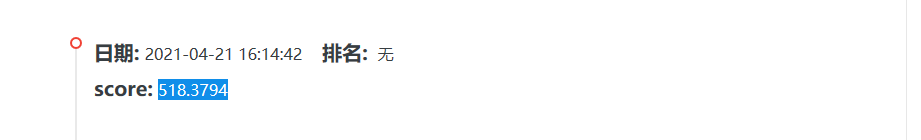